# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача**

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок. Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Задача проекта
* Разарботать и протестировать модель машинного обучения для классификации комментариев на позитивные и негативные.

## Подготовка

### Загрузка библиотек

In [1]:
# Файлы и директории
import os

# Датафреймы
import pandas as pd

# Математика
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Обработка текстов
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize

# Машинное обучение
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
    GridSearchCV)

# Предупреждения
import warnings
warnings.filterwarnings('ignore')

# Константы
RANDOM_STATE = 42
RANDOM_SEED = 42
CTR_RANDOM_SEED = 12345
CV_SPLITS = 3

In [2]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

### Загрузка данных

In [3]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
    
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)

else:
    print('Something went wrong')

###  Знакомство с данными

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df.head(3)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0


Столбец `Unnamed: 0`, по всей видимости, является артефактом. Индексы в нём совпадают с индексом строк, поэтому можем его удалить:

In [6]:
# Удаление столбца
df = df.drop('Unnamed: 0', axis=1)

Проверим датасет на наличие пропусков и дубликатов:

In [7]:
# Пропуски
df.isna().sum()

text     0
toxic    0
dtype: int64

In [8]:
# Дубликаты
df.duplicated().sum()

0

Проверим баланс классов. Отобразим общее количество значений:

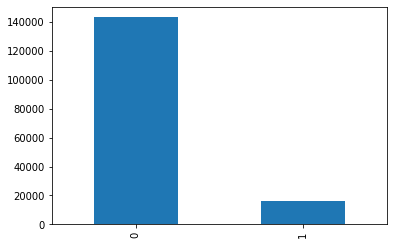

In [9]:
df['toxic'].value_counts().plot.bar();

Рассчитаем соотношение:

In [10]:
round(df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1], 3)

8.841

Токсичных комментариев почти в 9 раз меньше, чем нетоксичных.

### Очистка и лемматизация текстов

Разработаем функции для обработки комментариев: 

In [11]:
# Функция очистки
def clear_text(text):
    
    # Всё, кроме английских букв и апострофа заменяется пробелами  
    re_list = re.sub(r"[^a-zA-Z']", ' ', text.lower())
    
    # Деление на слова
    re_list = re_list.split()
    
    # Объединение через пробелы
    re_list = ' '.join(re_list)
    
    return re_list

In [12]:
# Инициализация лемматайзера
wnl = WordNetLemmatizer()

# Обработка сокращений
def expand_contractions(word):
    contractions = {
        "can't": "cannot",
        "won't": "will not",
        "n't": "not",
        "'s": "is",
        "'m": "am",
    }
    return contractions.get(word.lower(), word)

# Преобразование тегов Penn Treebank --> WordNet.
def penn2morphy(penntag):
    
    morphy_tag = {
        'NN':'n', 'JJ':'a',
        'VB':'v', 'RB':'r'
    }
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
# Лемматизация
def lemmatize_text(text): 
    
    # Объединение массива лематизированных слов в единую строку
    lemm_text = ' '.join([wnl.lemmatize(expand_contractions(word),
                                        pos=penn2morphy(tag)) 
                          for word, tag in pos_tag(word_tokenize(text))])
    
    return lemm_text

Произведём очистку и лемматизацию исходных данных:

In [13]:
df['clear_text'] = df['text'].apply(clear_text)
df['lemm_text'] = df['clear_text'].apply(lemmatize_text)

df.head()

,text,toxic,clear_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm se...,d'aww he match this background colour i be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...,hey man i be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...,more i ca not make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


Преобразование выполнено корректно.

### Разделение на выборки

Выделим корпус из лемматизированных текстов:

In [14]:
# Корпус как массив значений столбца датафрейма
corpus = df['lemm_text'].values

Выделим обучающие признаки и целевую переменную.

In [15]:
X = corpus
y = df['toxic'].values

Так как подбор гиперпараметров и расчёт F1-меры мы будем проводить с помощью кросс-валидации, разделим данные только на обучающую и тестовую выборки в соотношении 80:20. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE)

# Проверка
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((127433,), (127433,), (31859,), (31859,))

Рассчитаем TF-IDF и преобразуем выборки:

In [17]:
# Список распространённых стоп-слов
stopwords_en = list(stopwords.words('english'))

# Матрица TF-IDF
tf_idf = TfidfVectorizer(stop_words=stopwords_en)

Для того, чтобы на кросс-валидации не было утечки данных, отделим невекторизованные признаки. Сам векторайзер поместим в пайплайн.

In [18]:
# Отделение невекторизованных признаков для пайплайна кросс-валидации
X_train_cv = X_train
y_train_cv = y_train

Теперь векторизуем признаки для финального обучения и тестирования моделей.

In [19]:
# Преобразование признаков
X_train = tf_idf.fit_transform(X_train)
X_test = tf_idf.transform(X_test)

### Итоги этапа
* Данные успешно загружены и осмотрены.
* Проведена очистка и лемматизация.
* Подготовлены обучающие и тестовые выборки для обучения моделей.

## Обучение

Проведём кросс-валидацию трёх моделей на невекторизованных признаках. Для каждой соберём пайплайн из векторайзера и мдели. Проверим, какая из трёх покажет лучшие результаты по F1-мере на кросс-валидации.

### Логистическая регрессия

In [20]:
# Инициализация векторайзера
vectorizer = TfidfVectorizer(stop_words=stopwords_en)

# Инициализация модели
model = LogisticRegression()

# Сетка гиперпараметров
param_grid = {
    'model__C': [5, 10, 15],                   # Регуляризация
    'model__penalty': ['l1', 'l2'],            # Lasso vs. Ridge
    'model__max_iter': [100],                  # Число итераций для сходимости
    'model__class_weight': ['balanced'],       # Балансировка классов
    'model__random_state': [RANDOM_STATE]
}

# Пайплайн
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

# Инициализация и обучение GridSearch
gscv = GridSearchCV(pipeline,
                    param_grid,
                    scoring='f1',
                    cv=CV_SPLITS)
gscv.fit(X_train_cv, y_train_cv)

# Вывод гиперпараметров и F1-меры
print(f"Лучшие гиперпараметры: {gscv.best_params_}")
print(f"Значение F1: {gscv.best_score_}")

Лучшие гиперпараметры: {'model__C': 10, 'model__class_weight': 'balanced', 'model__max_iter': 100, 'model__penalty': 'l2', 'model__random_state': 42}
Значение F1: 0.7571065837616623


In [21]:
# Очистка префиксов гиперпараметров
best_params = {k.replace('model__', ''): v for k, v in gscv.best_params_.items()}

# Инициализация и обучение модели с лучшими гиперпараметрами
LR_model = LogisticRegression(**best_params)
LR_model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', random_state=42)

### Случайный лес

In [22]:
# Инициализация векторайзера
vectorizer = TfidfVectorizer(stop_words=stopwords_en)

# Инициализация модели
model = RandomForestClassifier()

# Сетка гиперпараметров
param_grid = {'model__max_depth': (7, 9),             # Глубина деревьев
              'model__n_estimators': (10, 100),       # Количество деревьев в ансамбле
              'model__class_weight': ['balanced'],    # Балансировка классов
              'model__random_state': [RANDOM_STATE]}

# Пайплайн
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

# Инициализация и обучение GridSearch
gscv = GridSearchCV(pipeline,
                    param_grid,
                    scoring='f1',
                    cv=CV_SPLITS)
gscv.fit(X_train_cv, y_train_cv)

# Вывод гиперпараметров и F1-меры
print(f"Лучшие гиперпараметры: {gscv.best_params_}")
print(f"Значение F1: {gscv.best_score_}")

Лучшие гиперпараметры: {'model__class_weight': 'balanced', 'model__max_depth': 9, 'model__n_estimators': 100, 'model__random_state': 42}
Значение F1: 0.3477101785243362


Даже с лучшими гиперпараметрами модель **Случайного Леса** не подходит из-за низкого значения F1-меры.

### LightGBM

In [23]:
# Инициализация векторайзера
vectorizer = TfidfVectorizer(stop_words=stopwords_en)

# Инициализация модели
model = LGBMClassifier()

param_grid = {
    'model__num_leaves': [31],
    'model__learning_rate': [0.05, 0.1],
    'model__n_estimators': [100],
}

# Пайплайн
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

# Инициализация и обучение GridSearch
gscv = GridSearchCV(pipeline,
                    param_grid,
                    scoring='f1',
                    cv=CV_SPLITS)
gscv.fit(X_train_cv, y_train_cv)

# Вывод гиперпараметров и F1-меры
print(f"Лучшие гиперпараметры: {gscv.best_params_}")
print(f"Значение F1: {gscv.best_score_}")

Лучшие гиперпараметры: {'model__learning_rate': 0.1, 'model__n_estimators': 100, 'model__num_leaves': 31}
Значение F1: 0.7433607816323358


Модель **LightGBM** смогла преодолеть порог по метрике F-1, но её значение ниже чем у **Логистической регрессии**.

### Итоги этапа 

* Модель **Случайного леса** не подходит по требованиям задачи из-за низкого значения F1-меры.
* **Логистическая регрессия** и **LightGBM** показали значения F1-меры выше порогового.

## Тестирование

### Логистическая регрессия

In [24]:
y_pred = LR_model.predict(X_test)
print(f"Значение F1: {f1_score(y_test, y_pred)}")

Значение F1: 0.7638728323699423


Модель **Логистической регрессии** показала значение F1-меры выше порогового, как на кросс-валидации, так и на тестовой выборке.

---

## Выводы

Задачей проекта заключалась в разработке и тестировании модели машинного обучения для классификации комментариев.

С помощью `GridSearchCV` были подобраны оптимальные гиперпараметры для трёх моделей:
* **Логистическая Регрессия**
* **Слаучайный Лес**
* **LightGBM**

Лучшей оказалась модель **Логистической Регрессии**, которая показала на тестовой выборке значение метрики F1=0,763. Именно эту модель мы и рекомендуем к внедрению.

---